In [3]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

## Data

Info about this data set: https://fred.stlouisfed.org/series/IPN31152N


Units:  Index 2012=100, Not Seasonally Adjusted

Frequency:  Monthly

The industrial production (IP) index measures the real output of all relevant establishments located in the United States, regardless of their ownership, but not those located in U.S. territories.

NAICS = 31152

Source Code: IP.N31152.N

Suggested Citation:
Board of Governors of the Federal Reserve System (US), Industrial Production: Nondurable Goods: Ice cream and frozen dessert [IPN31152N], retrieved from FRED, Federal Reserve Bank of St. Louis; https://fred.stlouisfed.org/series/IPN31152N, November 16, 2019.

# Project Tasks

**TASK: Read in the data set "Frozen_Dessert_Production.csv" from the Data folder. Figure out how to set the date to a datetime index columns**

In [54]:
df = pd.read_csv("C:/Users/John Lang/Documents/Data Science Machine Learning/Data Science/Tensorflow/DATA/Frozen_Dessert_Production.csv",index_col='DATE',parse_dates=True)

In [55]:
df.head()

,IPN31152N
DATE,
1972-01-01,59.9622
1972-02-01,67.0605
1972-03-01,74.2350
1972-04-01,78.1120
1972-05-01,84.7636


In [56]:
df.columns=['Production']

In [57]:
df

,Production
DATE,
1972-01-01,59.9622
1972-02-01,67.0605
1972-03-01,74.2350
1972-04-01,78.1120
1972-05-01,84.7636
...,...
2019-05-01,114.5613
2019-06-01,124.9605
2019-07-01,110.2632


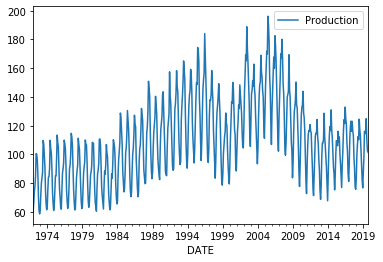

In [58]:
df.plot()

In [59]:
len(df)

573

In [60]:
test_size = 12
test_ind = len(df) - test_size

In [61]:
train = df.iloc[:test_ind]
test = df.iloc[test_ind:]

In [62]:
len(test)

12

In [63]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [64]:
scaler.fit(train)

MinMaxScaler(copy=True, feature_range=(0, 1))

In [65]:
scaled_train = scaler.transform(train)

In [66]:
scaled_test = scaler.transform(test)

In [67]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [68]:
length = 12
n_features = 1
generator = TimeseriesGenerator(scaled_train, scaled_train,
                               length=length, batch_size=1)

In [69]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

In [70]:
model = Sequential()
model.add(LSTM(150, input_shape=(length, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 150)               91200     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 151       
Total params: 91,351
Trainable params: 91,351
Non-trainable params: 0
_________________________________________________________________


In [73]:
validation_generator = TimeseriesGenerator(scaled_test, scaled_test,
                                           length=11, batch_size=1)

In [74]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=2)

In [75]:
model.fit(generator, epochs=20, validation_data=validation_generator,
         callbacks=[early_stop])

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 549 steps, validate for 1 steps
Epoch 1/20
549/549 [==============================] - 5s 9ms/step - loss: 0.0179 - val_loss: 7.5633e-04
Epoch 2/20
549/549 [==============================] - 3s 5ms/step - loss: 0.0047 - val_loss: 0.0015
Epoch 3/20
549/549 [==============================] - 3s 5ms/step - loss: 0.0039 - val_loss: 0.0021


In [76]:
losses = pd.DataFrame(model.history.history)

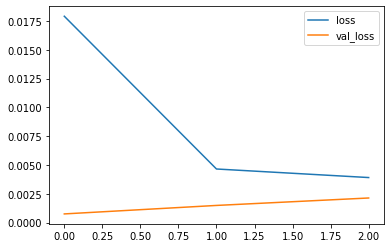

In [77]:
losses.plot()

In [78]:
test_predictions = []

# 1 month into future
first_eval_batch = scaled_train[-length:]

#3d
current_batch = first_eval_batch.reshape((1, length, n_features))

#forecast on the test set - get one timestamp ahead
for i in range(len(test)):
    
    #for last 24 months, what does first predictions look like
    current_pred = model.predict(current_batch)[0]
    
    #store the predictions
    test_predictions.append(current_pred)

    #Drop the first value, and add in current value - moving into future
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [79]:
test_predictions

[array([0.221869], dtype=float32),
 array([0.16972262], dtype=float32),
 array([0.17774428], dtype=float32),
 array([0.23010388], dtype=float32),
 array([0.30400708], dtype=float32),
 array([0.37749165], dtype=float32),
 array([0.4451155], dtype=float32),
 array([0.49680495], dtype=float32),
 array([0.52620345], dtype=float32),
 array([0.50181204], dtype=float32),
 array([0.4353826], dtype=float32),
 array([0.33381867], dtype=float32)]

In [80]:
true_predictions = scaler.inverse_transform(test_predictions)

In [81]:
test['Predictions'] = true_predictions

C:\Users\John Lang\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


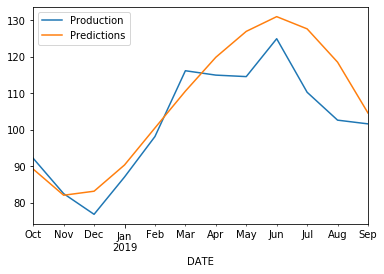

In [83]:
test.plot()

In [84]:
# Calculate RMSE
from sklearn.metrics import mean_squared_error
np.sqrt(mean_squared_error(test['Production'],test['Predictions']))

8.549528261249396